# Regularization and Logistic Regression

### Loading packages

In [1]:
# Import a bunch of libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
# regularization methos
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
# import data set
from sklearn.datasets import load_iris

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

### Loading data
Using pandas we import the data from a csv-file.

In [2]:
data = pd.read_csv('LinRegData.csv')
print(data.head())

# Extract features X and ouput Y
Y = data['output']
X = data.drop('output', axis=1).values

# Split into train and test data
m = X.shape[0]
print('\n Number of samples:', m)
shuffle = np.random.permutation(np.arange(m))
X, Y = X[shuffle], Y[shuffle]
X_train = X[:int(m*0.6), :]
Y_train = Y[:int(m*0.6)]
X_dev = X[int(m*0.6):int(m*0.8), :]
Y_dev = Y[int(m*0.6):int(m*0.8)]
X_test = X[int(m*0.8):, :]
Y_test = Y[int(m*0.8):]                                                  

   feature0  feature1  feature2    output
0 -0.030438 -0.586283  3.371215  0.324861
1 -0.018274  0.508692 -3.773249  4.062470
2 -0.029183 -1.305260 -1.928349 -6.495241
3 -0.034172 -1.255773 -6.919072  2.040479
4  0.141417  1.280515 -4.702404  3.007641

 Number of samples: 200


We apply data scaling and engineer polynomial features as seen in the last notebook.

In [3]:
def RMSE(output, prediction):
    return np.sqrt(np.mean((output - prediction)**2))

scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_dev_scaled = scaler.transform(X_dev)
X_test_scaled = scaler.transform(X_test)

poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
X_train_scaled_d2 = poly.fit_transform(X_train_scaled)
X_dev_scaled_d2 = poly.fit_transform(X_dev_scaled)
X_test_scaled_d2 = poly.fit_transform(X_test_scaled)

### L2 regularization
Ridge is the sklearn implementation of Linear Regression with L2-regularization.

In [4]:
lm = LinearRegression()
lm.fit(X_train_scaled_d2, Y_train)
preds = lm.predict(X_dev_scaled_d2)
lm_dev_rmse = RMSE(Y_dev, preds)

rm = Ridge(alpha=1000)
rm.fit(X_train_scaled_d2, Y_train)
preds = rm.predict(X_dev_scaled_d2)
rm_dev_rmse = RMSE(Y_dev, preds)

print("Linear model test RMSE:     ", lm_dev_rmse)
print("Ridge regression test RMSE: ", rm_dev_rmse)
print("Linear regression does worse on the test set: ", lm_dev_rmse > rm_dev_rmse)

Linear model test RMSE:      1.27980430843
Ridge regression test RMSE:  5.86813856166
Linear regression does worse on the test set:  False


Now, let's see what happens to the coefficients as alpha changes. Here's an investigation for a single coefficient. What happens to other coefficients? How is this reducing complexity? You can also try out making a *regularization path plot*, see:

http://fa.bianp.net/blog/2011/ridge-regression-path/

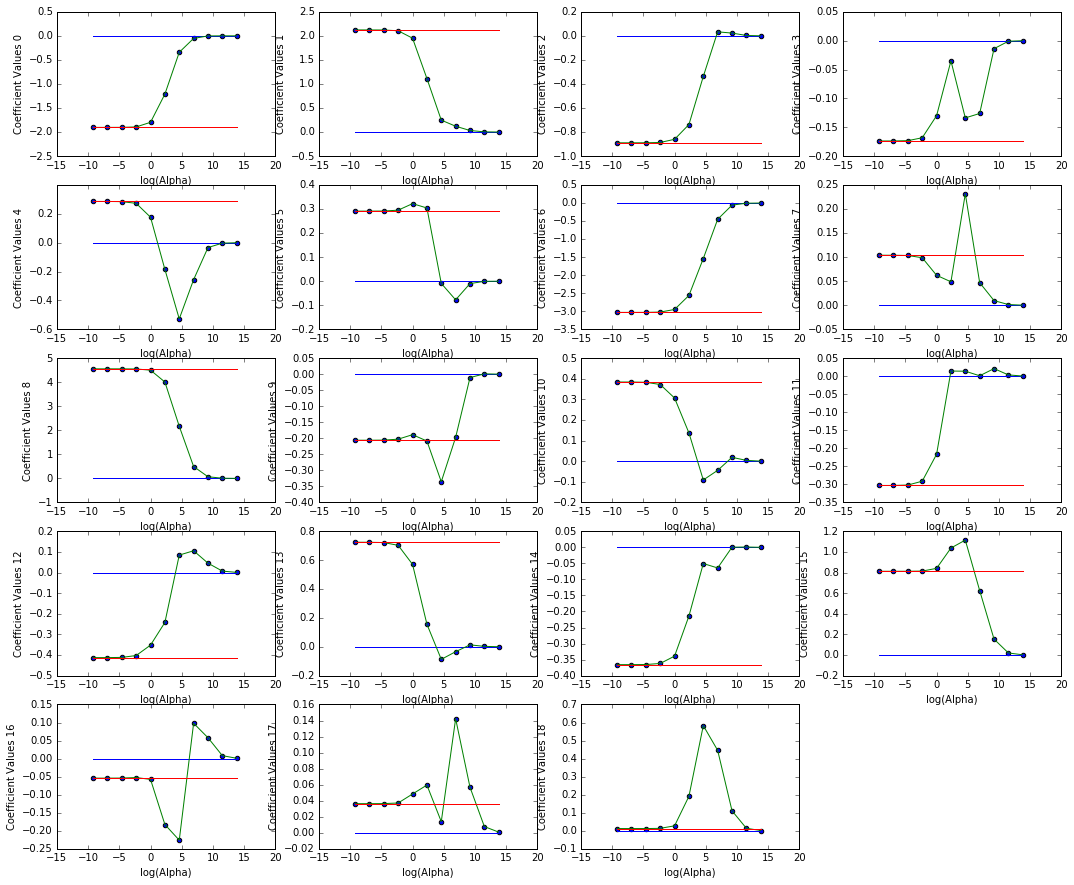

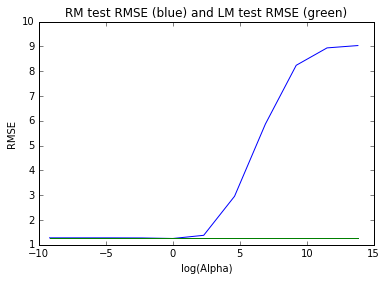

With alpha = 1.0000 we have the smallest rm test error 1.254713


In [5]:
alpha_vec = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5, 1e6]
coef_idx = 1
coef_values = np.zeros(len(alpha_vec))
lm_coef_line = np.zeros(len(alpha_vec))

lm = LinearRegression()
lm.fit(X_train_scaled_d2, Y_train)
preds = lm.predict(X_dev_scaled_d2)
lm_dev_rmse = RMSE(Y_dev, preds)

fig = plt.figure(figsize=(18,15))
rm_dev_rmse_vec = []
lm_dev_rmse_vec = []
nn = len(lm.coef_)
nn_count = 0

for coef_idx in range(nn):
    nn_count += 1
    for aa_idx, aa in enumerate(alpha_vec):
        rm = Ridge(alpha=aa)
        rm.fit(X_train_scaled_d2, Y_train)
        rm_coef = rm.coef_[coef_idx]
        lm_coef = lm.coef_[coef_idx]
    
        coef_values[aa_idx] = rm_coef
        lm_coef_line[aa_idx] = lm_coef
    
        if coef_idx == 0:
            preds = rm.predict(X_dev_scaled_d2)
            rm_dev_rmse = RMSE(Y_dev, preds)
            rm_dev_rmse_vec.append(rm_dev_rmse)
            lm_dev_rmse_vec.append(lm_dev_rmse)
        
    ax = fig.add_subplot(int(nn/4)+1, 4, nn_count)    
    ax.plot(np.log(alpha_vec), lm_coef_line * 0)    
    ax.plot(np.log(alpha_vec), coef_values)
    ax.plot(np.log(alpha_vec), lm_coef_line)
    ax.scatter(np.log(alpha_vec), coef_values)
    ax.set_ylabel('Coefficient Values '+str(nn_count-1))
    ax.set_xlabel('log(Alpha)') 
plt.show()

plt.plot(np.log(alpha_vec), rm_dev_rmse_vec)
plt.plot(np.log(alpha_vec), lm_dev_rmse_vec)
plt.title('RM test RMSE (blue) and LM test RMSE (green)')
plt.xlabel('log(Alpha)')
plt.ylabel('RMSE')
plt.show()

rm_best_alpha = alpha_vec[int(np.argmin(rm_dev_rmse_vec))]
print("With alpha = %.4f we have the smallest rm test error %f" %(rm_best_alpha, min(rm_dev_rmse_vec)))

In [6]:
rm = Ridge(alpha = rm_best_alpha)
rm.fit(X_train_scaled_d2, Y_train)
rm_coefs = rm.coef_
print(rm_coefs)

[-1.79728523  1.95104494 -0.86033139 -0.13003171  0.17665719  0.32238751
 -2.95105704  0.06221057  4.50026111 -0.18866513  0.30659859 -0.2164502
 -0.35198895  0.57102118 -0.3392478   0.84069362 -0.05756106  0.04835791
  0.02732903]


### L1 regularization
Lasso is the sklearn implementation of Linear Regression with L1-regularization.

In [7]:
lm = LinearRegression()
lm.fit(X_train_scaled_d2, Y_train)
preds = lm.predict(X_dev_scaled_d2)
lm_dev_rmse = RMSE(Y_dev, preds)

las = Lasso(alpha=10)
las.fit(X_train_scaled_d2, Y_train)
preds = las.predict(X_dev_scaled_d2)
las_dev_rmse = RMSE(Y_dev, preds)

print("Linear model test RMSE:     ", lm_dev_rmse)
print("Lasso regression test RMSE: ", las_dev_rmse)
print("Linear regression does worse on the test set: ", lm_dev_rmse > las_dev_rmse)

Linear model test RMSE:      1.27980430843
Lasso regression test RMSE:  8.49075343386
Linear regression does worse on the test set:  False


Now, let's see what happens to the coefficients as alpha changes. Here's an investigation for a single coefficient. What happens to other coefficients? How is this reducing complexity? You can also try out making a *regularization path plot*.

/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


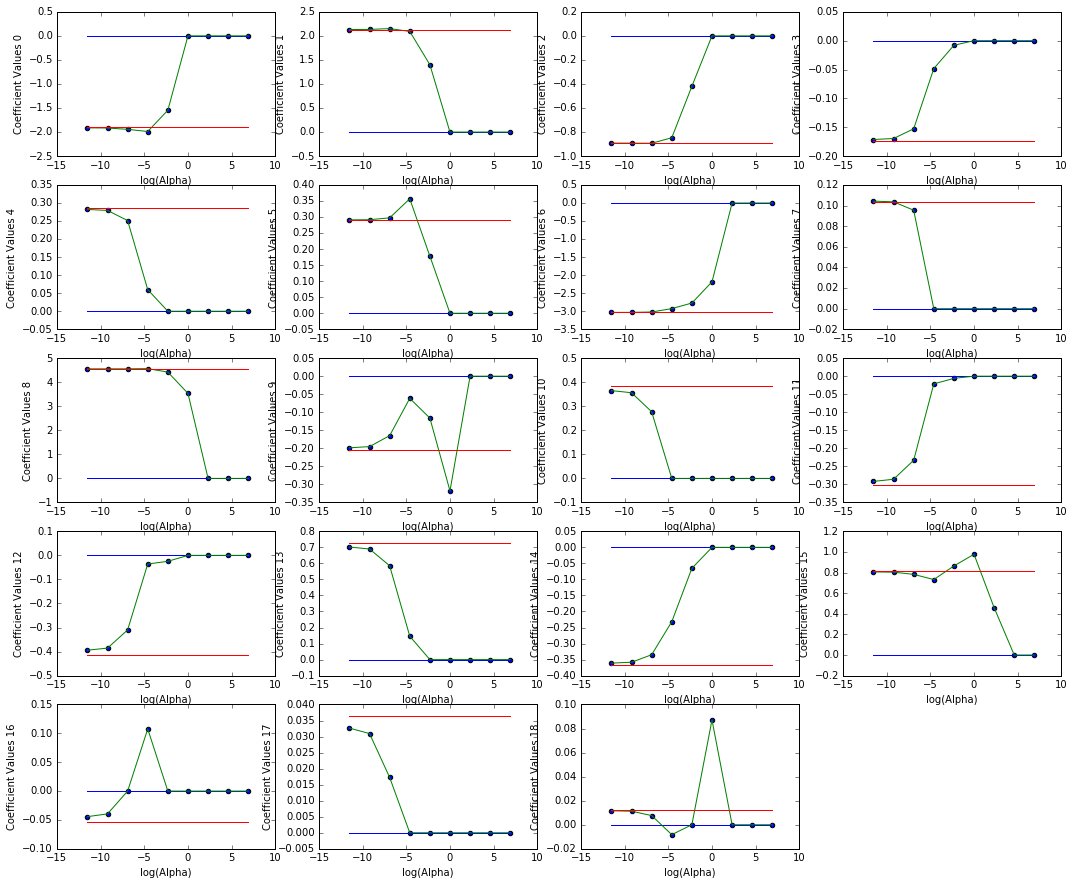

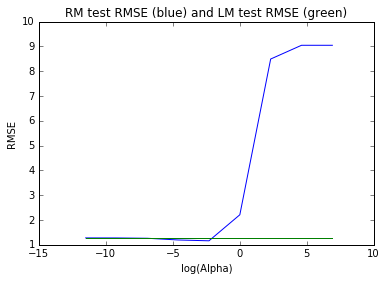

With alpha = 0.1000 we have the smallest rm test error 1.161029


In [8]:
alpha_vec = [1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10, 100, 1e3]
coef_idx = 1
coef_values = np.zeros(len(alpha_vec))
lm_coef_line = np.zeros(len(alpha_vec))

lm = LinearRegression()
lm.fit(X_train_scaled_d2, Y_train)
preds = lm.predict(X_dev_scaled_d2)
lm_dev_rmse = RMSE(Y_dev, preds)

fig = plt.figure(figsize=(18,15))
las_dev_rmse_vec = []
lm_dev_rmse_vec = []
nn = len(lm.coef_)
nn_count = 0

for coef_idx in range(nn):
    nn_count += 1
    for aa_idx, aa in enumerate(alpha_vec):
        las = Lasso(alpha=aa)
        las.fit(X_train_scaled_d2, Y_train)
        las_coef = las.coef_[coef_idx]
        lm_coef = lm.coef_[coef_idx]
    
        coef_values[aa_idx] = las_coef
        lm_coef_line[aa_idx] = lm_coef
    
        if coef_idx == 0:
            preds = las.predict(X_dev_scaled_d2)
            las_dev_rmse = RMSE(Y_dev, preds)
            las_dev_rmse_vec.append(las_dev_rmse)
            lm_dev_rmse_vec.append(lm_dev_rmse)
        
    ax = fig.add_subplot(int(nn/4)+1, 4, nn_count)    
    ax.plot(np.log(alpha_vec), lm_coef_line * 0)    
    ax.plot(np.log(alpha_vec), coef_values)
    ax.plot(np.log(alpha_vec), lm_coef_line)
    ax.scatter(np.log(alpha_vec), coef_values)
    ax.set_ylabel('Coefficient Values '+str(nn_count-1))
    ax.set_xlabel('log(Alpha)') 
plt.show()

plt.plot(np.log(alpha_vec), las_dev_rmse_vec)
plt.plot(np.log(alpha_vec), lm_dev_rmse_vec)
plt.title('RM test RMSE (blue) and LM test RMSE (green)')
plt.xlabel('log(Alpha)')
plt.ylabel('RMSE')
plt.show()

las_best_alpha = alpha_vec[int(np.argmin(las_dev_rmse_vec))]
print("With alpha = %.4f we have the smallest rm test error %f" %(las_best_alpha, min(las_dev_rmse_vec)))

In [9]:
las = Lasso(alpha = las_best_alpha)
las.fit(X_train_scaled_d2, Y_train)
las_coefs = las.coef_
print("The coefficients are: \n", las_coefs)
print("\nUnimportant features:")
for coef in np.where(las_coefs == 0)[0]:
    print(poly.get_feature_names()[coef])

print("\nImportant features:")
for coef in np.where(las_coefs != 0)[0]:
    print(poly.get_feature_names()[coef])

The coefficients are: 
 [-1.54625368  1.40075    -0.41907525 -0.00802462 -0.          0.17815996
 -2.77198379  0.          4.41996125 -0.11604541 -0.         -0.00607287
 -0.0247436  -0.         -0.06532379  0.86359822 -0.          0.         -0.        ]

Unimportant features:
x0 x1
x1 x2
x0^2 x1
x0 x1 x2
x1^2 x2
x1 x2^2
x2^3

Important features:
x0
x1
x2
x0^2
x0 x2
x1^2
x2^2
x0^3
x0^2 x2
x0 x1^2
x0 x2^2
x1^3


We apply our final model to the test set and calculate the test error.

In [10]:
las = Lasso(alpha = las_best_alpha)
las.fit(np.concatenate((X_train_scaled_d2, X_dev_scaled_d2), axis=0), np.concatenate((Y_train, Y_dev), axis = 0))
preds = las.predict(X_test_scaled_d2)
error = RMSE(Y_test, preds)
print("Test error: ", error)

Test error:  1.10111472356


## Classification and Logistic Regression

In [11]:
# Load the data, which is included in sklearn.
iris = load_iris()
target_names = iris.target_names
feature_names = iris.feature_names
print('Iris target names:', target_names[:2])
print('Iris feature names:', feature_names)
targets_idx = np.where(iris.target > 0)
X, Y = iris.data[targets_idx], iris.target[targets_idx]

# Shuffle the data, but make sure that the features and accompanying labels stay in sync.
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

# Split into train and test.
X_train, Y_train = X[:70], Y[:70]
X_test, Y_test = X[70:], Y[70:]

Iris target names: ['setosa' 'versicolor']
Iris feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


### Plotting the data

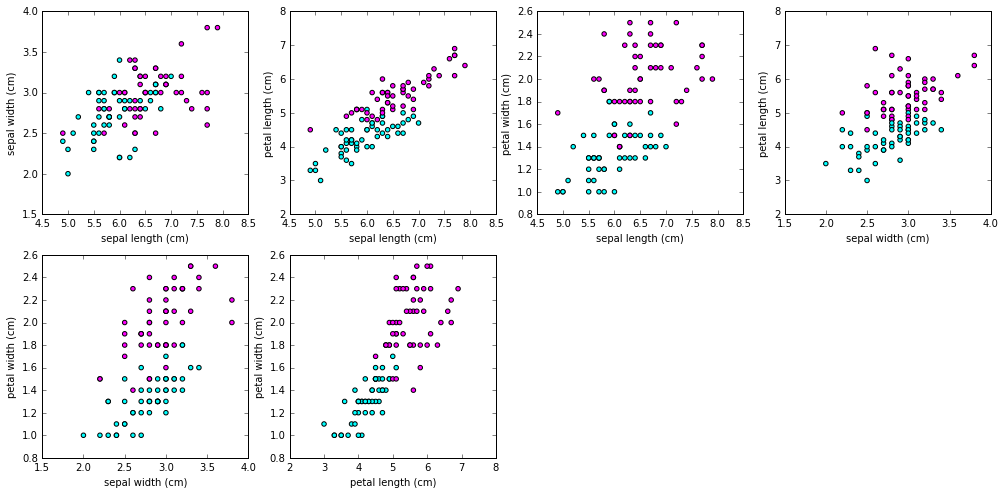

In [12]:
 
fig = plt.figure(figsize=(17,8))
ax1 = fig.add_subplot(2,4,1)
ax1.scatter(X[:,0], X[:,1], c = Y, cmap=plt.cm.cool)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])

ax2 = fig.add_subplot(2,4,2)
ax2.scatter(X[:,0], X[:,2], c = Y, cmap=plt.cm.cool)
ax2.set_xlabel(feature_names[0])
ax2.set_ylabel(feature_names[2])

ax3 = fig.add_subplot(2,4,3)
ax3.scatter(X[:,0], X[:,3], c = Y, cmap=plt.cm.cool)
ax3.set_xlabel(feature_names[0])
ax3.set_ylabel(feature_names[3])

ax4 = fig.add_subplot(2,4,4)
ax4.scatter(X[:,1], X[:,2], c = Y, cmap=plt.cm.cool)
ax4.set_xlabel(feature_names[1])
ax4.set_ylabel(feature_names[2])

ax5 = fig.add_subplot(2,4,5)
ax5.scatter(X[:,1], X[:,3], c = Y, cmap=plt.cm.cool)
ax5.set_xlabel(feature_names[1])
ax5.set_ylabel(feature_names[3])

ax6 = fig.add_subplot(2,4,6)
ax6.scatter(X[:,2], X[:,3], c = Y, cmap=plt.cm.cool)
ax6.set_xlabel(feature_names[2])
ax6.set_ylabel(feature_names[3])

plt.show()

### Logistic regression

In [13]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)
preds = lr.predict(X_test)
accuracy = np.mean(preds == Y_test)
print("Accuracy is: ", accuracy)
print("Predictions:    ", preds[:20])
print("Correct labels: ", Y_test[:20])

## with lr.predict_proba we obtain the results after application of the sigmoid function. 
## lr.predict returns the argmax of lr.predict_proba
probs = lr.predict_proba(X_test)
print("Certainties: \n", probs[:20])

## Let's have a look at the probabilities of the wrongly predicted samples
wrongs = np.where(preds != Y_test)
print("\nCertainties of wrong predictions:\n", probs[wrongs])

Accuracy is:  0.966666666667
Predictions:     [1 1 1 2 2 2 2 2 2 2 1 1 2 1 1 2 2 1 2 2]
Correct labels:  [1 1 1 2 2 2 1 2 2 2 1 1 2 1 1 2 2 1 2 2]
Certainties: 
 [[ 0.8771419   0.1228581 ]
 [ 0.96468009  0.03531991]
 [ 0.83834859  0.16165141]
 [ 0.30718744  0.69281256]
 [ 0.1404146   0.8595854 ]
 [ 0.2561519   0.7438481 ]
 [ 0.46979066  0.53020934]
 [ 0.09063024  0.90936976]
 [ 0.0808456   0.9191544 ]
 [ 0.42280336  0.57719664]
 [ 0.91547938  0.08452062]
 [ 0.77083576  0.22916424]
 [ 0.46462749  0.53537251]
 [ 0.82889182  0.17110818]
 [ 0.75890652  0.24109348]
 [ 0.16939656  0.83060344]
 [ 0.12122009  0.87877991]
 [ 0.89683938  0.10316062]
 [ 0.43757982  0.56242018]
 [ 0.15640516  0.84359484]]

Certainties of wrong predictions:
 [[ 0.46979066  0.53020934]]


Find the best regularization parameter for L2-regularization.

In [14]:
c_vec = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

for c in c_vec:
    lr = LogisticRegression(penalty='l2', C=c)
    lr.fit(X_train, Y_train)
    preds = lr.predict(X_test)
    accuracy = np.mean(preds == Y_test)
    print("C is: ", c)
    print("Accuracy is: ", accuracy, "\n")

C is:  0.0001
Accuracy is:  0.533333333333 

C is:  0.001
Accuracy is:  0.533333333333 

C is:  0.01
Accuracy is:  0.666666666667 

C is:  0.1
Accuracy is:  0.966666666667 

C is:  1
Accuracy is:  0.966666666667 

C is:  10
Accuracy is:  0.933333333333 

C is:  100
Accuracy is:  0.933333333333 

C is:  1000
Accuracy is:  0.966666666667 

C is:  10000
Accuracy is:  0.9 

C is:  100000
Accuracy is:  0.9 



The best values for c are 0.1, 1, and 1000.

In [15]:
c_vec = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]

for c in c_vec:
    lr = LogisticRegression(penalty='l1', C=c)
    lr.fit(X_train, Y_train)
    preds = lr.predict(X_test)
    accuracy = np.mean(preds == Y_test)
    print("C is: ", c)
    print("Accuracy is: ", accuracy)
    coefs = lr.coef_[0]
    if np.any(coefs != 0):
        print("Important features are: ", np.where(coefs != 0)[0])
    if np.any(coefs == 0):
        print("Features with weight 0 are: ", np.where(coefs == 0)[0])
    print("Features weights in decreasing order: ", np.argsort(-coefs))
    print()
print('Most important feature: ', feature_names[2], feature_names[3])

C is:  0.0001
Accuracy is:  0.466666666667
Features with weight 0 are:  [0 1 2 3]
Features weights in decreasing order:  [0 1 2 3]

C is:  0.001
Accuracy is:  0.466666666667
Features with weight 0 are:  [0 1 2 3]
Features weights in decreasing order:  [0 1 2 3]

C is:  0.01
Accuracy is:  0.466666666667
Features with weight 0 are:  [0 1 2 3]
Features weights in decreasing order:  [0 1 2 3]

C is:  0.1
Accuracy is:  0.533333333333
Important features are:  [2]
Features with weight 0 are:  [0 1 3]
Features weights in decreasing order:  [2 0 1 3]

C is:  1
Accuracy is:  0.9
Important features are:  [0 1 2 3]
Features weights in decreasing order:  [3 2 0 1]

C is:  10
Accuracy is:  0.933333333333
Important features are:  [0 1 2 3]
Features weights in decreasing order:  [3 2 0 1]

C is:  100
Accuracy is:  0.966666666667
Important features are:  [0 1 2 3]
Features weights in decreasing order:  [3 2 0 1]

C is:  1000
Accuracy is:  0.9
Important features are:  [0 1 2 3]
Features weights in decre

Accuracy is best with C = 100. Feature 2 and 3 seem to be most predictive.